In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

from utils.conversion import t2s, s2t, t2h, dt1h
from utils.parallel import bcast_by_root
from utils.progress import timer
from scripts.ensemble_forecast import ensemble_forecast
from assim_tools.state import parse_state_info, distribute_state_tasks, partition_grid, prepare_state, output_state, output_ens_mean
from assim_tools.obs import parse_obs_info, distribute_obs_tasks, prepare_obs, prepare_obs_from_state, assign_obs, distribute_partitions
from assim_tools.transpose import transpose_forward, transpose_backward
from assim_tools.analysis import batch_assim, serial_assim
from assim_tools.update import update_restart


In [2]:
from config import Config
c = Config(config_file='../config/samples/vort2d_testcase.yml')

##you can temporarily change settings too
#c.cycle_period = 3
c.assim_mode = 'batch'
c.filter_type = 'ETKF'


In [3]:
model_name = 'vort2d'
model = c.model_config[model_name]

In [4]:
##function to plot the wind field from the state
def plot_state(state, vmin=-30, vmax=30, cmap='bwr', title=''):
    fig, ax = plt.subplots(1, 1, figsize=(5,4))

    ##show the u-component wind in colors
    im = c.grid.plot_field(ax, state[0, ...], vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)

    ##show the vectors
    c.grid.plot_vectors(ax, state)
    
    ax.set_xlim(c.grid.xmin, c.grid.xmax)
    ax.set_ylim(c.grid.ymin, c.grid.ymax)
    ax.set_title(title)
    
##and from the obs
def plot_obs(obs_seq, obs_rec_id, v, vmin=-30, vmax=30, marker_size=20, cmap='bwr'):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))

    obs = obs_seq[obs_rec_id]['obs'][v, :]
    obs_x = obs_seq[obs_rec_id]['x']
    obs_y = obs_seq[obs_rec_id]['y']
    
    cmap = [plt.get_cmap(cmap)(x) for x in np.linspace(0, 1, round(vmax-vmin)+1)]
    cind = np.maximum(np.minimum(np.round(obs-vmin), int(np.round(vmax-vmin))), 0).astype(int)
    ax.scatter(obs_x, obs_y, marker_size, color=np.array(cmap)[cind, 0:3], edgecolor='k', linewidth=0.5)
    
    ax.set_xlim(c.grid.xmin, c.grid.xmax)
    ax.set_ylim(c.grid.ymin, c.grid.ymax)
    

In [5]:
##set up working directory, make sure it's created in your system
os.system("mkdir -p "+c.work_dir)

##initialize time control
c.time = c.time_start
c.prev_time = c.time
c.next_time = c.time


**Part 1**: prepare the truth (nature runs)

In [6]:
np.random.seed(0)  ##set a random seed if you want results reproducible
truth_dir = c.model_def[model_name]['truth_dir']
model.generate_initial_condition(path=truth_dir, name='velocity', time=c.time_start, is_vector=True)


In [7]:
##run the forecast to generate truth for the entire period

t = c.time_start
while t < c.time_end:
    next_t = t + c.cycle_period * dt1h
    model.run(path=truth_dir, time=t, forecast_period=c.cycle_period)
    t = next_t
    

**Part 2**: create initial perturbed ensemble

In [8]:
path = os.path.join(c.work_dir,'cycle',t2s(c.time_start),model_name)
os.system("mkdir -p "+path)

for m in range(c.nens):
    ##each member will have a different vortex position, given c.loc_sprd
    model.generate_initial_condition(path=path, member=m, name='velocity', time=c.time_start, is_vector=True)


**Part 3**: start cycling DA (you manually cycle through 3.1 and 3.2 below)

**3.1** - forecast step (in run_exp.py this step is done by ensemble_forecast.py)

In [15]:
c.next_time = c.time + c.cycle_period * dt1h

print('current cycle:', c.time, '->', c.next_time)


current cycle: 2001-01-01 03:00:00 -> 2001-01-01 06:00:00


In [16]:
##run the ensemble forecast from time to next_time
ensemble_forecast(c, model_name)


start vort2d ensemble forecast
........................................| 100% done.


**3.2** - analysis step (in run_exp.py this step is done by assimilate.py)

run the following cells if you want to perform DA for this cycle

In [17]:
##analysis time, c.time is used internally in module_assim
c.time = c.next_time

c.nproc = 1
c.nproc_mem = 1
c.s_dir = ''

analysis_dir = os.path.join(c.work_dir, 'cycle', t2s(c.time), 'analysis',c.s_dir)
os.system("mkdir -p "+analysis_dir)

##get state info
c.state_info = bcast_by_root(c.comm)(parse_state_info)(c)

##distribute mem_id and rec_id among processors
##here we use only 1 processor in the notebook, so it does all the work
c.mem_list, c.rec_list = bcast_by_root(c.comm)(distribute_state_tasks)(c)

##partition the analysis grid
c.partitions = bcast_by_root(c.comm)(partition_grid)(c)

##get field-complete state variables
fields_prior, z_fields = timer(c)(prepare_state)(c)

##output to binary files
##ensemble state
timer(c)(output_state)(c, fields_prior, os.path.join(analysis_dir, 'prior_state.bin'))

##ensemble mean state
timer(c)(output_ens_mean)(c, fields_prior, os.path.join(analysis_dir, 'prior_mean_state.bin'))

##z coordinates
output_ens_mean(c, z_fields, os.path.join(analysis_dir, 'z_coords.bin'))


timer: prepare_state took 0.28914809226989746 seconds

timer: output_state took 0.048720598220825195 seconds

timer: output_ens_mean took 0.005185127258300781 seconds



In [18]:
##get obs info
c.obs_info = bcast_by_root(c.comm)(parse_obs_info)(c)

##distribute obs_rec_id among processors
c.obs_rec_list = bcast_by_root(c.comm)(distribute_obs_tasks)(c)

##read dataset and prepare the obs sequence
c.obs_info, obs_seq = timer(c)(bcast_by_root(c.comm_mem)(prepare_obs))(c)

##assign obs to each partition
c.obs_inds = bcast_by_root(c.comm_mem)(assign_obs)(c, obs_seq)

##figure out the workload on each partition
##and distribute the par_id among processors
c.par_list = bcast_by_root(c.comm)(distribute_partitions)(c)

##prepare the obs priors, call state_to_obs
##to apply the forward obs operators
obs_prior_seq = timer(c)(prepare_obs_from_state)(c, obs_seq, fields_prior, z_fields)


timer: prepare_obs took 0.07576894760131836 seconds

timer: prepare_obs_from_state took 0.03210186958312988 seconds



In [19]:
##transpose from field-complete to ensemble-complete
state_prior, z_state, lobs, lobs_prior = timer(c)(transpose_forward)(c, fields_prior, z_fields, obs_seq, obs_prior_seq)

##the core assimilation algorithm

if c.assim_mode == 'batch':
    assimilate = batch_assim
elif c.assim_mode == 'serial':
    assimilate = serial_assim
    
state_post = timer(c)(assimilate)(c, state_prior, z_state, lobs, lobs_prior)

##transpose back to field-complete
fields_post = timer(c)(transpose_backward)(c, state_post)

##output posterior files
timer(c)(output_ens_mean)(c, fields_post, os.path.join(analysis_dir, 'post_mean_state.bin'))
timer(c)(output_state)(c, fields_post, os.path.join(analysis_dir, 'post_state.bin'))

##update model restart files
timer(c)(update_restart)(c, fields_prior, fields_post)


timer: transpose_forward took 0.017772674560546875 seconds

assimilate in batch mode:
........................................| 100% done.
timer: batch_assim took 3.927767276763916 seconds

timer: transpose_backward took 0.008617401123046875 seconds

timer: output_ens_mean took 0.0063626766204833984 seconds

timer: output_state took 0.04689908027648926 seconds

timer: update_restart took 0.15709710121154785 seconds



In [20]:
##go to next cycle
c.prev_time = c.time
c.time = c.next_time

##you can jump back to part 3 again


**Part 4**: Diagnostics of filter performance

In [ ]:
##you can visualize the obs_seq by
plot_obs(obs_seq, obs_rec_id=0, v=0)

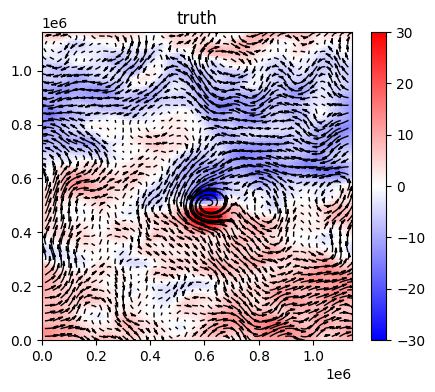

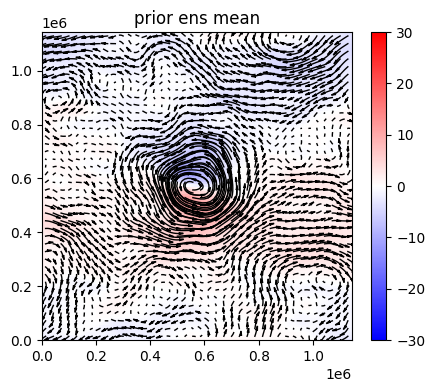

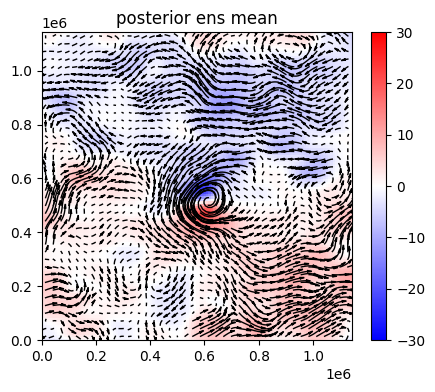

In [44]:
##plot the field to compare
t = s2t('200101010300')
prev_t = t - c.cycle_period * dt1h

##truth
path = c.work_dir+'/truth/'+t2s(t)+'/'+model_name
true_state = model.read_var(path=path, name='velocity', is_vector=True, time=t)
plot_state(true_state, title='truth')

##ens-mean prior
path = c.work_dir+'/cycle/'+t2s(prev_t)+'/'+model_name
ens_state_prior = np.zeros((c.nens,)+true_state.shape)
for m in range(c.nens):
    ens_state_prior[m, ...] = model.read_var(path=path, name='velocity', is_vector=True, time=t, member=m)
plot_state(np.mean(ens_state_prior, axis=0), title='prior ens mean')

##ens-mean posterior
path = c.work_dir+'/cycle/'+t2s(t)+'/'+model_name
ens_state_post = np.zeros((c.nens,)+true_state.shape)
for m in range(c.nens):
    ens_state_post[m, ...] = model.read_var(path=path, name='velocity', is_vector=True, time=t, member=m)
plot_state(np.mean(ens_state_post, axis=0), title='posterior ens mean')


Text(0, 0.5, 'm/s')

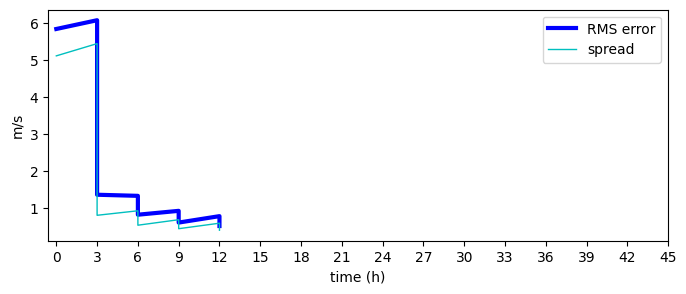

In [58]:
##sawtooth graph of rmse(ensemble_mean - truth) and sprd(ensemble)

t0 = c.time_start
t = t0
prev_t = t

h_ts = []
rmse_ts = []
sprd_ts = []
while t < c.time_end:
    next_t = t + c.cycle_period * dt1h

    ##truth
    path = c.work_dir+'/truth/'+t2s(t)+'/'+model_name
    truth = model.read_var(path=path, name='velocity', is_vector=True, time=t)

    ##ens-mean prior
    path = c.work_dir+'/cycle/'+t2s(prev_t)+'/'+model_name
    ens_state_prior = np.full((c.nens,)+true_state.shape, np.nan)
    for m in range(c.nens):
        if not os.path.exists(model.filename(path=path, time=t, member=m)):
            continue
        ens_state_prior[m, ...] = model.read_var(path=path, name='velocity', is_vector=True, time=t, member=m)
    prior_mean = np.mean(ens_state_prior, axis=0)
    prior_sprd = np.std(ens_state_prior, axis=0)

    ##ens-mean posterior
    path = c.work_dir+'/cycle/'+t2s(t)+'/'+model_name
    ens_state_post = np.full((c.nens,)+true_state.shape, np.nan)
    for m in range(c.nens):
        if not os.path.exists(model.filename(path=path, time=t, member=m)):
            continue
        ens_state_post[m, ...] = model.read_var(path=path, name='velocity', is_vector=True, time=t, member=m)
    post_mean = np.mean(ens_state_post, axis=0)
    post_sprd = np.std(ens_state_post, axis=0)

    h = (t - t0) / timedelta(hours=1)
    h_ts.append(h)
    rmse_ts.append(np.sqrt(np.mean((prior_mean - truth)**2)))
    sprd_ts.append(np.sqrt(np.mean(prior_sprd**2)))
    h_ts.append(h)
    rmse_ts.append(np.sqrt(np.mean((post_mean - truth)**2)))
    sprd_ts.append(np.sqrt(np.mean(post_sprd**2)))
    
    prev_t = t
    t = next_t

fig, ax = plt.subplots(1, 1, figsize=(8,3))
ax.plot(h_ts, rmse_ts, 'b', linewidth=3, label='RMS error')
ax.plot(h_ts, sprd_ts, 'c', linewidth=1, label='spread')
ax.legend()
ax.set_xticks(np.arange(0, (c.time_end-c.time_start)/dt1h, c.cycle_period))
ax.set_xlabel('time (h)')
ax.set_ylabel('m/s')